In [1]:
import os
import csv
import datetime
import pandas as pd
import optuna
import optuna.visualization as vis
from models.fir_regression import FIR_Regression
from models.support_vector_regression_with_RBF import SVR_RBF
from utils.loader import load_data_with_logReturn_black_swan
from utils.device import get_best_device

/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BacktestRunner:
    def __init__(self, model_class, model_config):
        self.model_class = model_class
        self.model_config = model_config
        self.model = model_class(**model_config)
        self.best_model = None
        self.eval_result = None
        self.sim_result = None
        self.sim_fig = None

    def train_optimal_model(self):
        self.model.train()
        self.best_model = self.model
        return self.best_model

    def evaluate_model(self):
        self.eval_result = self.model.evaluate()
        return self.eval_result

    def run_real_world_simulation(self, sim_class, sim_config):
        sim = sim_class(model=self.best_model.model,
                        scaler=self.model.scaler,
                        **sim_config)
        self.sim_result, self.sim_fig = sim.run_simulation()
        return self.sim_result, self.sim_fig

    def log_results(self, log_root="log", log_name=None):
        if self.eval_result is None or self.sim_result is None:
            raise ValueError("Must run evaluate_model and run_real_world_simulation before logging.")

        if log_name is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            log_name = f"log_{timestamp}"

        model_name = self.model_class.__name__
        log_dir = os.path.join(log_root, model_name)
        fig_dir = os.path.join(log_dir, "figs")
        os.makedirs(log_dir, exist_ok=True)
        os.makedirs(fig_dir, exist_ok=True)

        csv_path = os.path.join(log_dir, f"{log_name}.csv")

        # Unified config handling
        config_to_log = self.model_config["config"] if "config" in self.model_config else self.model_config.copy()
        config_to_log = config_to_log.copy()
        config_to_log["device"] = str(config_to_log.get("device", ""))

        log_entry = {
            "train_val_start": self.model_config["train_val_test_start"],
            "train_val_end": self.model_config["train_val_test_end"],
            "test_start": self.model_config["train_val_test_start"],
            "test_end": self.model_config["train_val_test_end"],
            **self.eval_result,
            **self.sim_result,
            **config_to_log
        }

        file_exists = os.path.isfile(csv_path)
        with open(csv_path, mode="a", newline="") as f:
            writer = csv.DictWriter(f, fieldnames=log_entry.keys())
            if not file_exists:
                writer.writeheader()
            writer.writerow(log_entry)

        # Save figure if available
        if hasattr(self, "sim_fig") and self.sim_fig is not None:
            fig_path = os.path.join(fig_dir, f"{log_name}.png")
            self.sim_fig.savefig(fig_path)
            print(f"[INFO] Saved figure to {fig_path}")


In [3]:
device = get_best_device()

## MLP

In [4]:
from models.mlp import MLP_Regression, MLP_Simulation

In [5]:
features = [
    "Open", "High", "Low", "Close", "Volume",
    "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
    "LogReturn_Lag4", "LogReturn_Lag5"
]

base_config_template = {
    "csv_path": "stocks/AAPL.csv",
    "features": features,
    "target": "LogReturn",
    "loader_func": load_data_with_logReturn_black_swan,
}


# Define candidate date ranges
date_ranges = [
    ('1990-01-01', '2000-01-01'),
    ('1992-01-01', '2002-01-01'),
    ('1994-01-01', '2004-01-01'),
    ('1996-01-01', '2006-01-01'),
    ('1998-01-01', '2008-01-01'),
    ('2000-01-01', '2010-01-01'),
    ('2002-01-01', '2012-01-01'),
    ('2004-01-01', '2014-01-01'),
    ('2006-01-01', '2016-01-01'),
    ('2008-01-01', '2018-01-01'),
    ('2010-01-01', '2020-01-01'),
    ('2012-01-01', '2022-01-01'),
]

def objective(trial):
    # Select a training date range
    train_start, train_end = trial.suggest_categorical("train_date_range", date_ranges)

    window = trial.suggest_int("window", 10, 120, step=10)
    stride = window  # Fix stride to be equal to window

    # More granular and diverse hyperparameter space
    config = {
        "window": window,
        "stride": stride,
        "shuffle_dataset": True,
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "lr": trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        "epochs": trial.suggest_int("epochs", 10, 50, step=5),
        "dropout_rate": trial.suggest_float("dropout_rate", 0.0, 0.6, step=0.05),
        "device": device,
        "hidden_sizes": trial.suggest_categorical("hidden_sizes", [
            [64], [128, 64], [256, 128], [256, 128, 64],
            [512, 256, 128], [512, 256, 128, 64]
        ])
    }

    # Inject time range into config
    base_config = {
        **base_config_template,
        "train_val_test_start": train_start,
        "train_val_test_end": train_end
    }

    mlp_config = {
        **base_config,
        "config": config
    }

    runner = BacktestRunner(MLP_Regression, mlp_config)
    runner.train_optimal_model()
    eval_result = runner.evaluate_model()
    
    return -eval_result["Val RMSE"]

In [6]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-07 13:51:40,194] A new study created in memory with name: no-name-3279d27c-bcdc-461f-9be0-a2513267e5b5
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1994-01-01', '2004-01-01') which

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:41,518] Trial 0 finished with value: -0.03655879944562912 and parameters: {'train_date_range': ('2006-01-01', '2016-01-01'), 'window': 20, 'batch_size': 128, 'lr': 0.005250466099331778, 'epochs': 30, 'dropout_rate': 0.6, 'hidden_sizes': [512, 256, 128]}. Best is trial 0 with value: -0.03655879944562912.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-p

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:41,896] Trial 1 finished with value: -0.035452570766210556 and parameters: {'train_date_range': ('2008-01-01', '2018-01-01'), 'window': 20, 'batch_size': 64, 'lr': 0.0001093545051215392, 'epochs': 30, 'dropout_rate': 0.2, 'hidden_sizes': [256, 128]}. Best is trial 1 with value: -0.035452570766210556.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-pack

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:42,485] Trial 2 finished with value: -0.16934998333454132 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 70, 'batch_size': 16, 'lr': 0.005122574918415972, 'epochs': 10, 'dropout_rate': 0.35000000000000003, 'hidden_sizes': [512, 256, 128]}. Best is trial 1 with value: -0.035452570766210556.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/p

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:42,928] Trial 3 finished with value: -0.032316915690898895 and parameters: {'train_date_range': ('2008-01-01', '2018-01-01'), 'window': 80, 'batch_size': 128, 'lr': 0.008302085787490518, 'epochs': 50, 'dropout_rate': 0.45, 'hidden_sizes': [256, 128, 64]}. Best is trial 3 with value: -0.032316915690898895.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:43,364] Trial 4 finished with value: -0.08145926147699356 and parameters: {'train_date_range': ('2012-01-01', '2022-01-01'), 'window': 70, 'batch_size': 16, 'lr': 0.009688185569208658, 'epochs': 25, 'dropout_rate': 0.25, 'hidden_sizes': [256, 128, 64]}. Best is trial 3 with value: -0.032316915690898895.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-p

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:43,744] Trial 5 finished with value: -0.05958063155412674 and parameters: {'train_date_range': ('1990-01-01', '2000-01-01'), 'window': 80, 'batch_size': 128, 'lr': 0.003341279853789417, 'epochs': 35, 'dropout_rate': 0.45, 'hidden_sizes': [512, 256, 128]}. Best is trial 3 with value: -0.032316915690898895.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:44,190] Trial 6 finished with value: -0.022339295595884323 and parameters: {'train_date_range': ('2008-01-01', '2018-01-01'), 'window': 80, 'batch_size': 16, 'lr': 0.0018440121178055586, 'epochs': 25, 'dropout_rate': 0.2, 'hidden_sizes': [128, 64]}. Best is trial 6 with value: -0.022339295595884323.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packa

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:44,975] Trial 7 finished with value: -0.03847416862845421 and parameters: {'train_date_range': ('1990-01-01', '2000-01-01'), 'window': 10, 'batch_size': 64, 'lr': 0.0003620078340023316, 'epochs': 35, 'dropout_rate': 0.6, 'hidden_sizes': [256, 128]}. Best is trial 6 with value: -0.022339295595884323.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packa

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:45,521] Trial 8 finished with value: -0.02170977182686329 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 50, 'batch_size': 16, 'lr': 7.868867342921214e-05, 'epochs': 25, 'dropout_rate': 0.4, 'hidden_sizes': [512, 256, 128]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-p

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:45,760] Trial 9 finished with value: -0.07358097285032272 and parameters: {'train_date_range': ('2004-01-01', '2014-01-01'), 'window': 20, 'batch_size': 128, 'lr': 0.001651738915451187, 'epochs': 35, 'dropout_rate': 0.0, 'hidden_sizes': [64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/opt

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:45,982] Trial 10 finished with value: -0.024160463362932205 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 120, 'batch_size': 32, 'lr': 1.1128511554062542e-05, 'epochs': 10, 'dropout_rate': 0.05, 'hidden_sizes': [512, 256, 128, 64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:46,413] Trial 11 finished with value: -0.031675998121500015 and parameters: {'train_date_range': ('2002-01-01', '2012-01-01'), 'window': 50, 'batch_size': 16, 'lr': 0.000103279515200006, 'epochs': 25, 'dropout_rate': 0.15000000000000002, 'hidden_sizes': [128, 64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:46,917] Trial 12 finished with value: -0.07859157770872116 and parameters: {'train_date_range': ('1994-01-01', '2004-01-01'), 'window': 50, 'batch_size': 16, 'lr': 0.0006185129755269354, 'epochs': 20, 'dropout_rate': 0.35000000000000003, 'hidden_sizes': [128, 64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:47,395] Trial 14 finished with value: -0.041471801698207855 and parameters: {'train_date_range': ('1998-01-01', '2008-01-01'), 'window': 100, 'batch_size': 32, 'lr': 0.0011561823319949517, 'epochs': 50, 'dropout_rate': 0.30000000000000004, 'hidden_sizes': [64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.1

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:47,827] Trial 15 finished with value: -0.03228297829627991 and parameters: {'train_date_range': ('1996-01-01', '2006-01-01'), 'window': 50, 'batch_size': 16, 'lr': 0.0001224371926155532, 'epochs': 15, 'dropout_rate': 0.45, 'hidden_sizes': [512, 256, 128, 64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:48,055] Trial 16 finished with value: -0.1010928824543953 and parameters: {'train_date_range': ('2000-01-01', '2010-01-01'), 'window': 100, 'batch_size': 16, 'lr': 3.8686728955773424e-05, 'epochs': 40, 'dropout_rate': 0.2, 'hidden_sizes': [128, 64]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packa

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:48,736] Trial 17 finished with value: -0.0432656928896904 and parameters: {'train_date_range': ('2008-01-01', '2018-01-01'), 'window': 40, 'batch_size': 16, 'lr': 0.00024033087053712676, 'epochs': 20, 'dropout_rate': 0.5, 'hidden_sizes': [512, 256, 128]}. Best is trial 8 with value: -0.02170977182686329.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:49,218] Trial 19 finished with value: -0.022681759670376778 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 90, 'batch_size': 64, 'lr': 0.0006036422234961629, 'epochs': 45, 'dropout_rate': 0.35000000000000003, 'hidden_sizes': [512, 256, 128]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/l

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:49,509] Trial 20 finished with value: -0.02704528160393238 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 40, 'batch_size': 64, 'lr': 2.7365579912734098e-05, 'epochs': 15, 'dropout_rate': 0.5, 'hidden_sizes': [512, 256, 128]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/si

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:49,746] Trial 21 finished with value: -0.0263390950858593 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 100, 'batch_size': 64, 'lr': 0.001962116766975865, 'epochs': 25, 'dropout_rate': 0.25, 'hidden_sizes': [512, 256, 128]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/sit

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64] which is of type list.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 64] which is of type list.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 128] which is of type list.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical dis

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:50,233] Trial 23 finished with value: -0.03931257128715515 and parameters: {'train_date_range': ('1992-01-01', '2002-01-01'), 'window': 80, 'batch_size': 64, 'lr': 0.00028377261866374464, 'epochs': 30, 'dropout_rate': 0.4, 'hidden_sizes': [512, 256, 128]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/si

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:50,482] Trial 24 finished with value: -0.06147103011608124 and parameters: {'train_date_range': ('1994-01-01', '2004-01-01'), 'window': 90, 'batch_size': 16, 'lr': 0.0035230850355109787, 'epochs': 20, 'dropout_rate': 0.15000000000000002, 'hidden_sizes': [256, 128]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/pyt

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:50,873] Trial 25 finished with value: -0.07330884039402008 and parameters: {'train_date_range': ('2012-01-01', '2022-01-01'), 'window': 60, 'batch_size': 16, 'lr': 5.1773196319561756e-05, 'epochs': 15, 'dropout_rate': 0.2, 'hidden_sizes': [64]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:51,157] Trial 26 finished with value: -0.029798099771142006 and parameters: {'train_date_range': ('1996-01-01', '2006-01-01'), 'window': 110, 'batch_size': 64, 'lr': 0.001997038024557333, 'epochs': 25, 'dropout_rate': 0.4, 'hidden_sizes': [512, 256, 128, 64]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.1

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:51,699] Trial 27 finished with value: -0.040110066533088684 and parameters: {'train_date_range': ('2004-01-01', '2014-01-01'), 'window': 40, 'batch_size': 32, 'lr': 0.00046300881297561326, 'epochs': 30, 'dropout_rate': 0.25, 'hidden_sizes': [256, 128, 64]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/s

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:51,919] Trial 28 finished with value: -0.03026633709669113 and parameters: {'train_date_range': ('2002-01-01', '2012-01-01'), 'window': 90, 'batch_size': 16, 'lr': 0.00017756266369184435, 'epochs': 40, 'dropout_rate': 0.1, 'hidden_sizes': [128, 64]}. Best is trial 18 with value: -0.014727498404681683.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-pac

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:52,302] Trial 30 finished with value: -0.020014112815260887 and parameters: {'train_date_range': ('1998-01-01', '2008-01-01'), 'window': 70, 'batch_size': 128, 'lr': 1.152490935616983e-05, 'epochs': 35, 'dropout_rate': 0.6, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/si

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:52,748] Trial 32 finished with value: -0.03580199554562569 and parameters: {'train_date_range': ('1998-01-01', '2008-01-01'), 'window': 60, 'batch_size': 128, 'lr': 1.3639353697868368e-05, 'epochs': 30, 'dropout_rate': 0.55, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/s

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:53,179] Trial 33 finished with value: -0.04133493825793266 and parameters: {'train_date_range': ('1998-01-01', '2008-01-01'), 'window': 30, 'batch_size': 128, 'lr': 2.0105187303828377e-05, 'epochs': 40, 'dropout_rate': 0.55, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/s

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:53,429] Trial 34 finished with value: -0.03938561677932739 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 70, 'batch_size': 128, 'lr': 6.816513675816085e-05, 'epochs': 30, 'dropout_rate': 0.55, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/si

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:53,822] Trial 36 finished with value: -0.04266148433089256 and parameters: {'train_date_range': ('2000-01-01', '2010-01-01'), 'window': 70, 'batch_size': 128, 'lr': 1.0515336376118656e-05, 'epochs': 35, 'dropout_rate': 0.6, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/si

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:54,072] Trial 37 finished with value: -0.06527320295572281 and parameters: {'train_date_range': ('1998-01-01', '2008-01-01'), 'window': 80, 'batch_size': 128, 'lr': 6.777118371713307e-05, 'epochs': 40, 'dropout_rate': 0.4, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/sit

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:54,333] Trial 38 finished with value: -0.044126614928245544 and parameters: {'train_date_range': ('2006-01-01', '2016-01-01'), 'window': 90, 'batch_size': 128, 'lr': 1.552666343258617e-05, 'epochs': 25, 'dropout_rate': 0.45, 'hidden_sizes': [256, 128, 64]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/si

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:54,562] Trial 39 finished with value: -0.04054605960845947 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 50, 'batch_size': 64, 'lr': 3.426607888744642e-05, 'epochs': 30, 'dropout_rate': 0.55, 'hidden_sizes': [256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-pac

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1994-01-01', '2004-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:55,135] Trial 41 finished with value: -0.04845523089170456 and parameters: {'train_date_range': ('2008-01-01', '2018-01-01'), 'window': 70, 'batch_size': 16, 'lr': 0.0010458161791663464, 'epochs': 25, 'dropout_rate': 0.30000000000000004, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:55,469] Trial 43 finished with value: -0.051233552396297455 and parameters: {'train_date_range': ('2008-01-01', '2018-01-01'), 'window': 80, 'batch_size': 16, 'lr': 0.00014277821137301448, 'epochs': 25, 'dropout_rate': 0.25, 'hidden_sizes': [128, 64]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-pa

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:55,825] Trial 44 finished with value: -0.14347554743289948 and parameters: {'train_date_range': ('2010-01-01', '2020-01-01'), 'window': 110, 'batch_size': 128, 'lr': 7.381609173951057e-05, 'epochs': 35, 'dropout_rate': 0.15000000000000002, 'hidden_sizes': [64]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:56,229] Trial 45 finished with value: -0.03030049055814743 and parameters: {'train_date_range': ('1998-01-01', '2008-01-01'), 'window': 70, 'batch_size': 16, 'lr': 1.0006748523548645e-05, 'epochs': 25, 'dropout_rate': 0.45, 'hidden_sizes': [512, 256, 128, 64]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.1

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:56,475] Trial 46 finished with value: -0.05360628664493561 and parameters: {'train_date_range': ('2012-01-01', '2022-01-01'), 'window': 60, 'batch_size': 32, 'lr': 0.0014920340866452413, 'epochs': 30, 'dropout_rate': 0.25, 'hidden_sizes': [256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-pac

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:56,791] Trial 47 finished with value: -0.04261883720755577 and parameters: {'train_date_range': ('2004-01-01', '2014-01-01'), 'window': 50, 'batch_size': 16, 'lr': 0.002755751014078174, 'epochs': 20, 'dropout_rate': 0.5, 'hidden_sizes': [128, 64]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packag

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:57,221] Trial 48 finished with value: -0.040209751576185226 and parameters: {'train_date_range': ('2002-01-01', '2012-01-01'), 'window': 30, 'batch_size': 128, 'lr': 2.7124974787245554e-05, 'epochs': 45, 'dropout_rate': 0.35000000000000003, 'hidden_sizes': [512, 256, 128]}. Best is trial 29 with value: -0.01219562254846096.
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1990-01-01', '2000-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/lib/python3.10/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains ('1992-01-01', '2002-01-01') which is of type tuple.
  warnings.warn(message)
/opt/anaconda3/envs/ee460_new_310/

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


[I 2025-05-07 13:51:57,464] Trial 49 finished with value: -0.04516563564538956 and parameters: {'train_date_range': ('1994-01-01', '2004-01-01'), 'window': 90, 'batch_size': 64, 'lr': 0.006034186531376798, 'epochs': 30, 'dropout_rate': 0.6, 'hidden_sizes': [256, 128, 64]}. Best is trial 29 with value: -0.01219562254846096.


In [7]:
# Create pic folder if it doesn't exist
os.makedirs("pic", exist_ok=True)

# Optimization history
fig1 = vis.plot_optimization_history(study)
fig1.update_layout(width=1200, height=800, font=dict(size=10))
fig1.write_image("pic/optimization_history.png")

# Hyperparameter importances
fig2 = vis.plot_param_importances(study)
fig2.update_layout(width=1200, height=800, font=dict(size=10))
fig2.write_image("pic/param_importances.png")

# Slice plot
fig3 = vis.plot_slice(study)
fig3.update_layout(width=1200, height=800, font=dict(size=10))
fig3.write_image("pic/slice_plot.png")

# Contour plot
fig4 = vis.plot_contour(study, params=["window", "dropout_rate", "lr"])
fig4.update_layout(width=1200, height=800, font=dict(size=10))
fig4.write_image("pic/contour_plot.png")

In [8]:
print(f"  Value (lowest Val RMSE): {study.best_trial.value:.6f}")

  Value (lowest Val RMSE): -0.012196


In [9]:
for key, value in study.best_params.items():
    print(f"    {key}: {value}")


    train_date_range: ('1998-01-01', '2008-01-01')
    window: 70
    batch_size: 128
    lr: 1.5088280760669432e-05
    epochs: 30
    dropout_rate: 0.55
    hidden_sizes: [512, 256, 128]


### Simulation

In [10]:
best_params = study.best_trial.params

# Unpack training range
train_start, train_end = best_params["train_date_range"]

# Rebuild config
best_config = {
    "window": best_params["window"],
    "batch_size": best_params["batch_size"],
    "shuffle_dataset": True,
    "lr": best_params["lr"],
    "epochs": best_params["epochs"],
    "dropout_rate": best_params["dropout_rate"],
    "hidden_sizes": best_params["hidden_sizes"]
}

# Rebuild full mlp_config
mlp_config = {
    **base_config_template,
    "train_val_test_start": train_start,
    "train_val_test_end": train_end,
    "config": best_config
}

runner = BacktestRunner(MLP_Regression, mlp_config)
runner.train_optimal_model()
runner.evaluate_model()

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


{'Train R2': -0.6815872192382812,
 'Val R2': -4.073108673095703,
 'Test R2': -0.0730353593826294,
 'Train RMSE': 0.04843005910515785,
 'Val RMSE': 0.039052385836839676,
 'Test RMSE': 0.0316285640001297}

Running simulation: 2022-01-01 → 2023-01-01
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)
Running simulation: 2022-07-01 → 2023-07-01
[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO

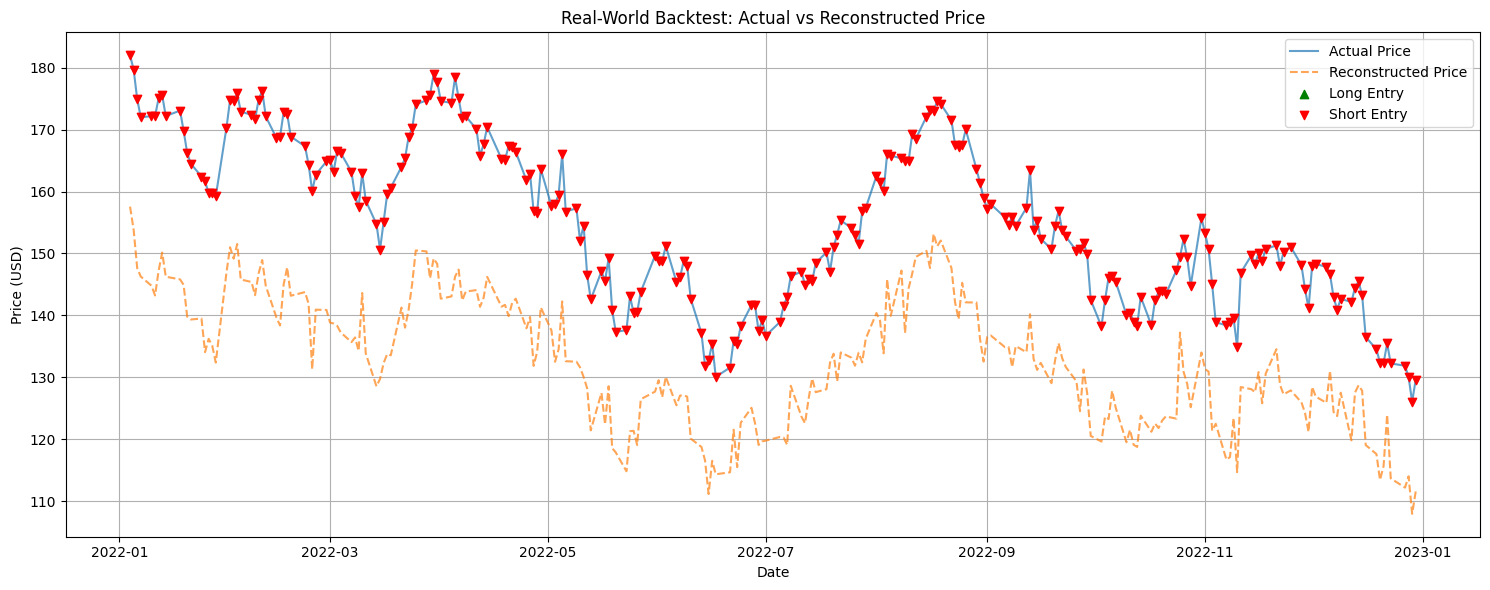

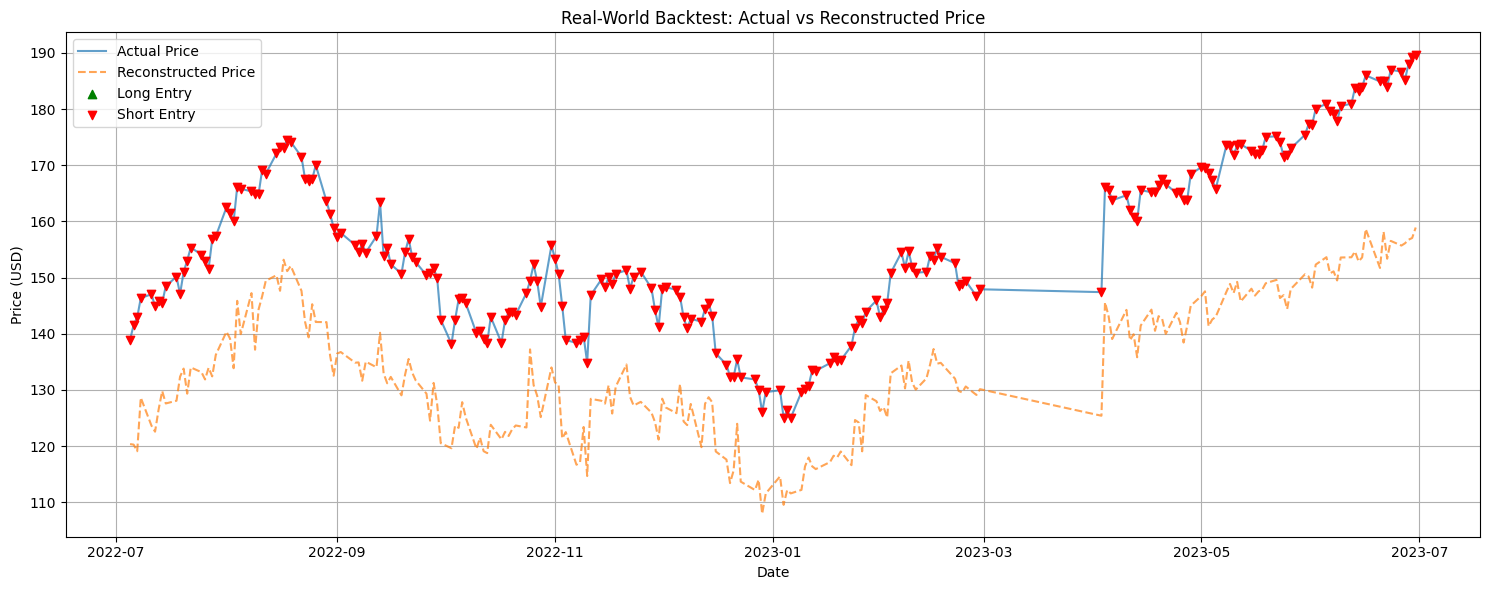

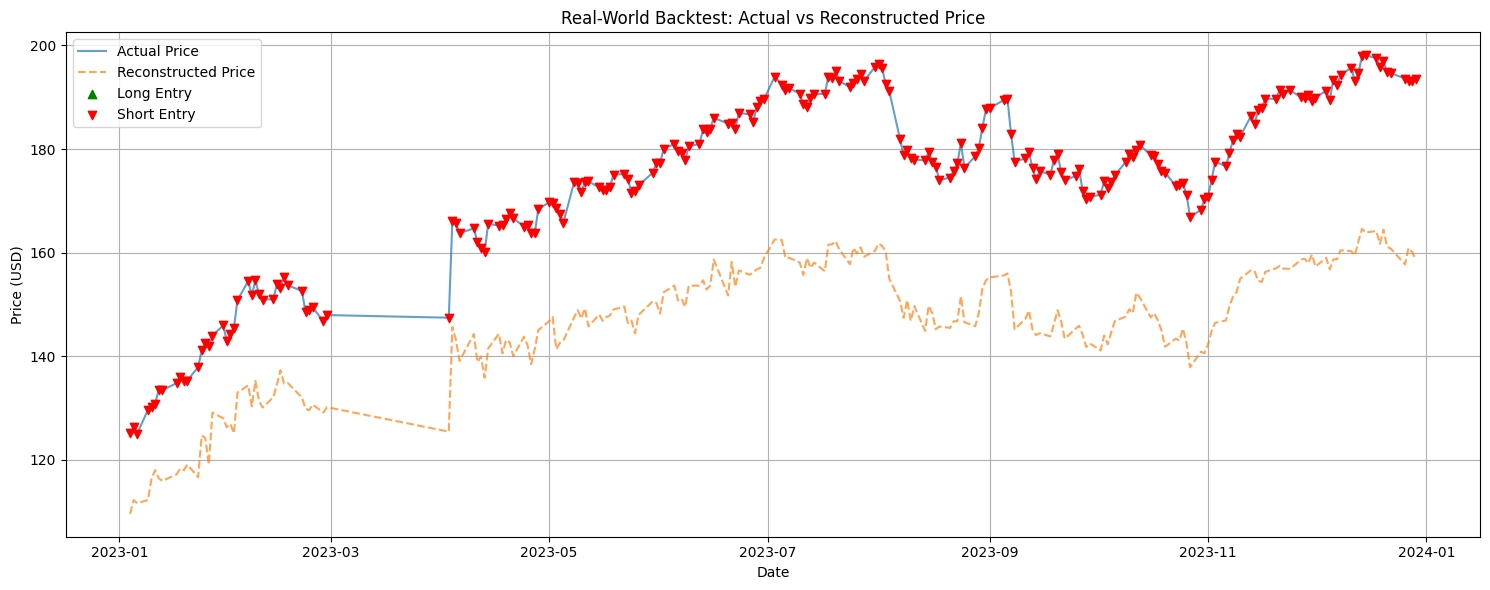

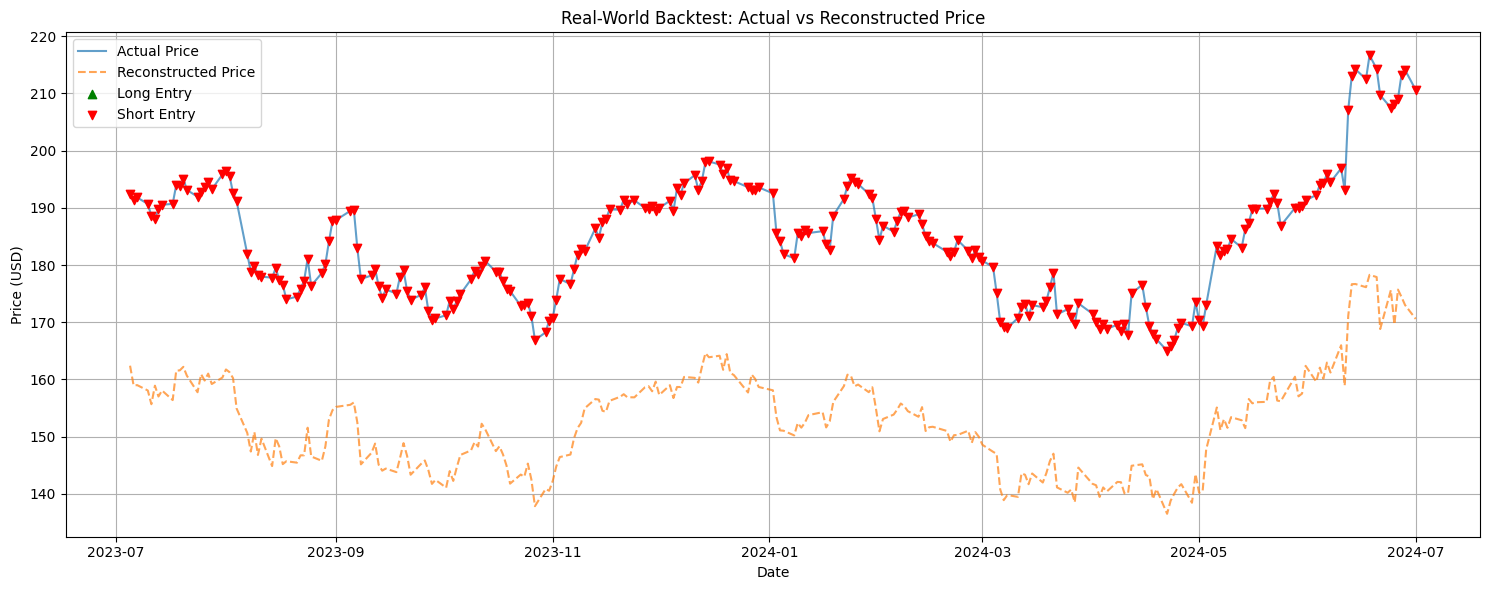

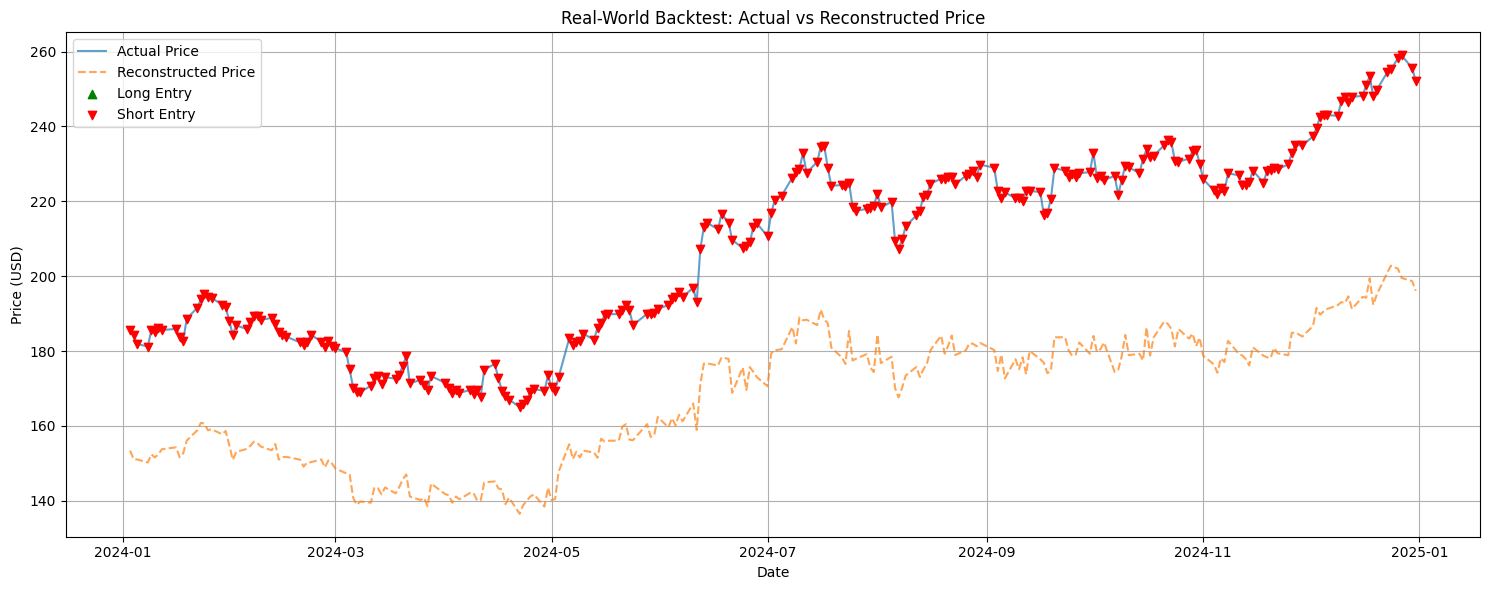

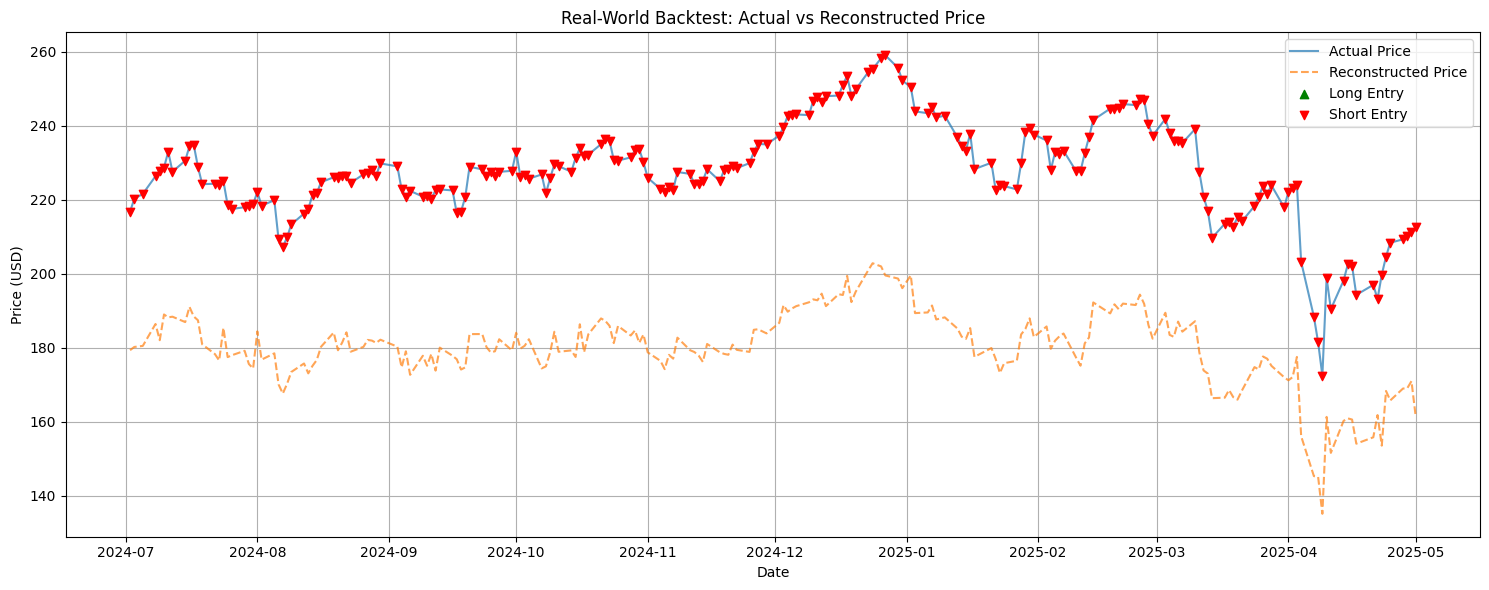

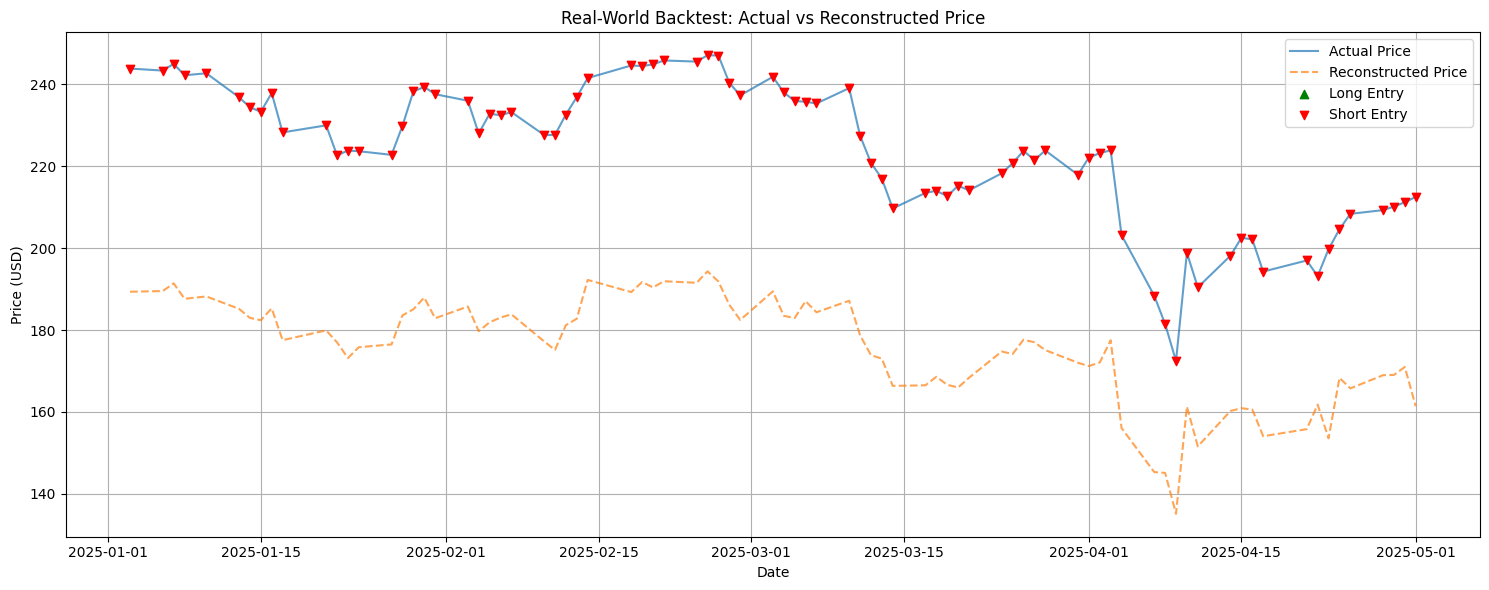

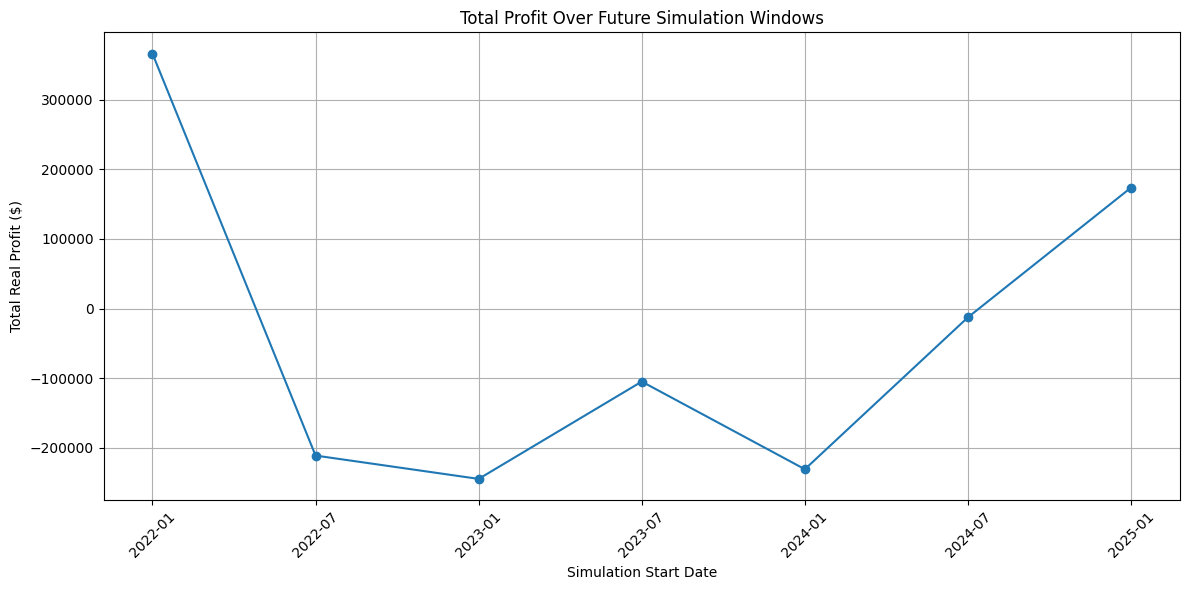

In [11]:
import matplotlib.pyplot as plt

# Define sliding simulation windows (e.g., 1 year each, after 2022-01-01)
sim_start_dates = pd.date_range("2022-01-01", "2025-01-01", freq="6MS").strftime("%Y-%m-%d").tolist()
window_length = pd.DateOffset(months=12)  # 1-year simulation

# Collect results
sim_results = []

for start_date_str in sim_start_dates:
    sim_start = pd.Timestamp(start_date_str)
    sim_end = sim_start + window_length
    sim_config = {
        "csv_path": base_config_template["csv_path"],
        "features": base_config_template["features"],
        "target": base_config_template["target"],
        "sim_start_date": sim_start,
        "sim_end_date": sim_end,
        "loader_func": base_config_template["loader_func"],
        "window": best_config["window"],
        "stride": 1,
        "batch_size": best_config["batch_size"],
        "device": device
    }

    print(f"Running simulation: {sim_start.date()} → {sim_end.date()}")
    try:
        result, _ = runner.run_real_world_simulation(MLP_Simulation, sim_config)
        sim_results.append({
            "start_date": sim_start,
            "end_date": sim_end,
            **result
        })
    except Exception as e:
        print(f"[Warning] Skipped {sim_start.date()} due to error: {e}")

# Convert to DataFrame
sim_df = pd.DataFrame(sim_results)
sim_df["Period"] = sim_df["start_date"].dt.strftime("%Y-%m")

# Plot Total Real Profit
plt.figure(figsize=(12, 6))
plt.plot(sim_df["Period"], sim_df["Total Real Profit"], marker="o")
plt.xticks(rotation=45)
plt.title("Total Profit Over Future Simulation Windows")
plt.xlabel("Simulation Start Date")
plt.ylabel("Total Real Profit ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
sim_config = {
    "csv_path": base_config_template["csv_path"],
    "features": base_config_template["features"],
    "target": base_config_template["target"],
    "sim_start_date": "2022-05-01",
    "sim_end_date": "2024-05-01",
    "loader_func": base_config_template["loader_func"],
    "window": best_config["window"],
    "stride": 1,
    "batch_size": best_config["batch_size"],
    "device": device
}

[INFO] Removed 649 rows for DotCom Bubble Crash (2000-03-01 to 2002-10-01)
[INFO] Removed 188 rows for 2008 Financial Crisis (2008-09-01 to 2009-06-01)
[INFO] Removed 2 rows for Flash Crash (2010-05-06 to 2010-05-07)
[INFO] Removed 127 rows for Eurozone Crisis (2011-07-01 to 2012-01-01)
[INFO] Removed 52 rows for COVID-19 Crash (2020-02-15 to 2020-04-30)
[INFO] Removed 23 rows for SVB Collapse (2023-03-01 to 2023-04-01)
[INFO] Final dataset size: 10141 rows (removed 1041 total)


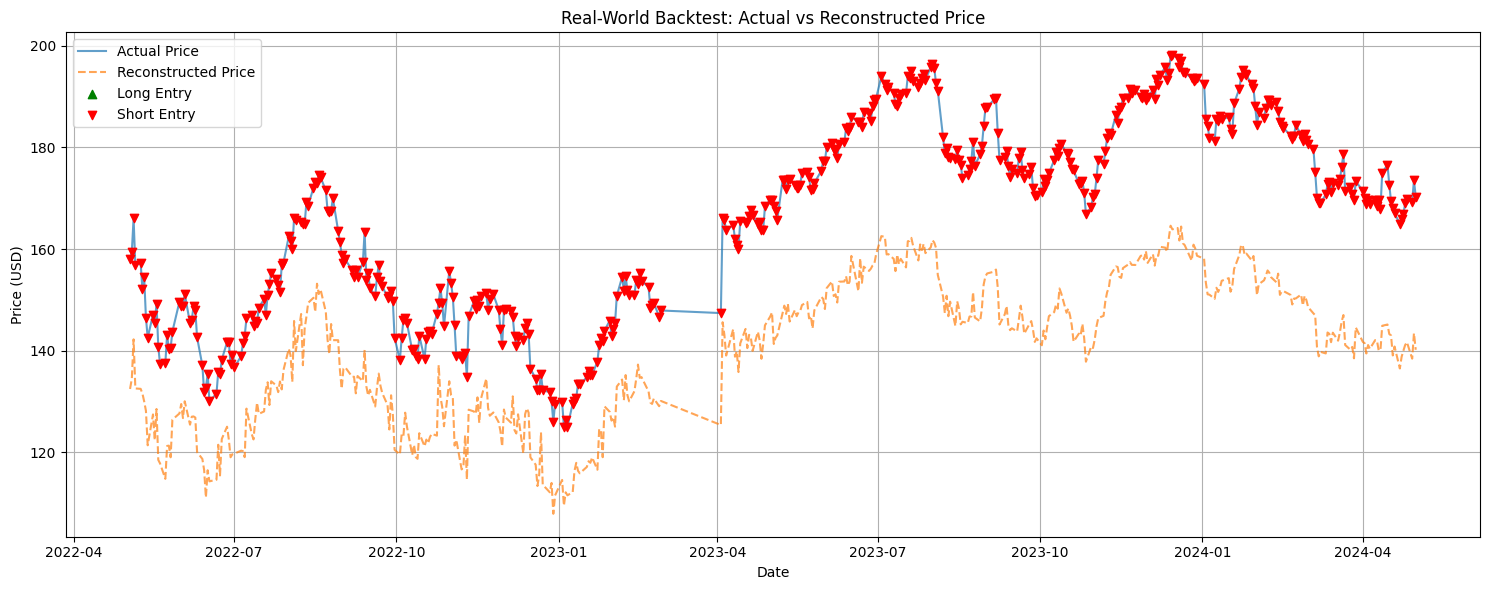

In [13]:
result_sim,_ = runner.run_real_world_simulation(MLP_Simulation, sim_config)

In [14]:
result_sim

{'Real Cumulative Return': np.float64(0.04167124296868496),
 'Real Sharpe Ratio': np.float64(0.07713984700776874),
 'Final Real Capital': np.float64(1041671.242968685),
 'Total Real Profit': np.float64(41671.242968684965),
 'Average PnL': np.float64(238.28163093792213),
 'Average PnL (%)': np.float64(0.023828163093792213)}

## Archive

In [15]:
# features = [
#     "Open", "High", "Low", "Close", "Volume",
#     "LogReturn_Lag1", "LogReturn_Lag2", "LogReturn_Lag3",
#     "LogReturn_Lag4", "LogReturn_Lag5"
# ]

# base_config_template = {
#     "csv_path": "stocks/AAPL.csv",
#     "features": features,
#     "target": "LogReturn",
#     "loader_func": load_data_with_logReturn
# }

# mlp_extra_config = {
#     "config": {
#         "window": 50,
#         "stride": 50,
#         "batch_size": 64,
#         "shuffle_train_set": False,
#         "lr": 1e-3,
#         "epochs": 20,
#         "dropout_rate": 0.2,
#         "device": device
#     }
# }

# sim_config = {
#     "csv_path": base_config_template["csv_path"],
#     "features": base_config_template["features"],
#     "target": base_config_template["target"],
#     "sim_start_date": "2019-05-01",
#     "sim_end_date": "2025-05-01",
#     "loader_func": base_config_template["loader_func"],
#     "window": 50,
#     "stride": 1,
#     "batch_size": 64,
#     "device": device
# }

# slide_start_dates = pd.date_range("1990-01-01", "2005-01-01", freq="5YS").strftime("%Y-%m-%d").tolist()

# for start in slide_start_dates:
#     start_year = int(start[:4])
#     end_year = start_year + 15
#     end = f"{end_year}-04-30" 

#     print(f"[INFO] Running experiment from {start} to {end}...")

#     base_config = {
#         **base_config_template,
#         "train_val_test_start": start,
#         "train_val_test_end": end,
#     }

#     mlp_config = {**base_config, **mlp_extra_config}

#     runner = BacktestRunner(MLP_Regression, mlp_config)
#     runner.train_optimal_model()
#     runner.evaluate_model()
#     runner.run_real_world_simulation(MLP_Simulation, sim_config)
#     runner.log_results(log_name=f"{start}_to_{end}")